# Analysis

## IMPORTING MODULES AND LIBRARIES

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix

#Importing miceforest for imputing the null values
import miceforest as mf

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from scipy.stats import chi2_contingency

from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
import plotly.express as px

%matplotlib inline

In [4]:
#Importing the dataset

data = pd.read_csv('corona_tested_006.csv')
data

C:\Users\ajaym\AppData\Local\Temp\ipykernel_6304\3027221815.py:3: DtypeWarning: Columns (2,3,4,5,6,8) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('corona_tested_006.csv')


,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed
...,...,...,...,...,...,...,...,...,...,...,...
278843,278844,30-04-2020,False,False,False,False,False,positive,NaN,male,Other
278844,278845,30-04-2020,False,False,False,False,False,negative,NaN,female,Other
278845,278846,30-04-2020,False,False,False,False,False,negative,NaN,male,Other
278846,278847,30-04-2020,False,False,False,False,False,negative,NaN,male,Other


In [5]:
#Checking the characteristics of the dataset

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               278848 non-null  int64 
 1   Test_date            278848 non-null  object
 2   Cough_symptoms       278596 non-null  object
 3   Fever                278596 non-null  object
 4   Sore_throat          278847 non-null  object
 5   Shortness_of_breath  278847 non-null  object
 6   Headache             278847 non-null  object
 7   Corona               278848 non-null  object
 8   Age_60_above         151528 non-null  object
 9   Sex                  259285 non-null  object
 10  Known_contact        278848 non-null  object
dtypes: int64(1), object(10)
memory usage: 23.4+ MB


# Exploring the Target Feature

In [7]:
#Checking the ratios of the Target Categories 

data['Corona'].value_counts()

Corona
negative    260227
positive     14729
other         3892
Name: count, dtype: int64

In [8]:
#Barplot of the frequency of the categories of the target feature 'Corona' 

sns.barplot(x=data['Corona'].value_counts().index, y=data['Corona'].value_counts())

<Axes: xlabel='Corona', ylabel='count'>

In [9]:
#Replacing the 'other' category in the 'Corona' to 'negative'

data['Corona'] = data['Corona'].replace('other', 'negative')

In [10]:
#Checking the categories of the 'Corona' feature

sns.barplot(x=data['Corona'].value_counts().index, y=data['Corona'].value_counts())

<Axes: xlabel='Corona', ylabel='count'>

In [11]:
#Percentage of the categories of the 'Corona' feature

corona = pd.DataFrame(data['Corona'].value_counts())
corona['%'] = (corona['count']/data.shape[0])*100
corona

,count,%
Corona,,
negative,264119,94.717911
positive,14729,5.282089


### It is concluded that the dataset is highly unbalanced dataset

In [13]:
#Getting all the categorical columns

cat_cols = list(data.select_dtypes('object').columns)
cat_cols.remove('Test_date')     # Removing the 'Test_date' feature name to check the unique categories of the other features
cat_cols

['Cough_symptoms',
 'Fever',
 'Sore_throat',
 'Shortness_of_breath',
 'Headache',
 'Corona',
 'Age_60_above',
 'Sex',
 'Known_contact']

In [14]:
#DISPLAYING THE UNIQUE VALUES OF EACH CATEGORICAL FEATURES USING A PANDAS DATAFRAME

for column in cat_cols:
    print(f"{column} : ", data[column].unique())
    print("\n")

Cough_symptoms :  [True False nan]


Fever :  [False True nan]


Sore_throat :  [True False nan]


Shortness_of_breath :  [False True nan]


Headache :  [False True nan]


Corona :  ['negative' 'positive']


Age_60_above :  [nan 'No' 'Yes']


Sex :  [nan 'male' 'female']


Known_contact :  ['Abroad' 'Contact with confirmed' 'Other']




## Checking if null values are present or not

In [16]:
#Calculating the null percentage

null = pd.DataFrame(data.isnull().sum())
null['null%'] = (null[0]/data.shape[0])*100
null

,0,null%
Ind_ID,0,0.000000
Test_date,0,0.000000
Cough_symptoms,252,0.090372
Fever,252,0.090372
Sore_throat,1,0.000359
Shortness_of_breath,1,0.000359
Headache,1,0.000359
Corona,0,0.000000
Age_60_above,127320,45.659284
Sex,19563,7.015650


# Checking the missingness of the 'Age_60_above' feature

In [18]:
#Getting all the records having value of 'Age_60_above' as NULL 
miss_age = data[data[['Age_60_above']].isnull().any(axis=1)]
miss_age.head(10)

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed
5,6,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed
6,7,11-03-2020,False,False,False,False,False,negative,NaN,NaN,Other
7,8,11-03-2020,False,True,False,False,False,negative,NaN,NaN,Abroad
8,9,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
9,10,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad


In [19]:
#Percentage distribution of the 'Cough_symptoms' feature for person below 60 age
aged_df = pd.DataFrame(data[data['Age_60_above']=='No']['Cough_symptoms'].value_counts())
aged_df['percentage'] = round((data[data['Age_60_above']=='No']['Cough_symptoms'].value_counts()/data[data['Age_60_above']=='No']['Cough_symptoms'].shape[0])*100, 2)
aged_df

,count,percentage
Cough_symptoms,,
False,102623,81.64
True,22883,18.20


In [20]:
#Percentage distribution of the 'Fever' feature for person below 60 age
aged_df = pd.DataFrame(data[data['Age_60_above']=='No']['Fever'].value_counts())
aged_df['percentage'] = round((data[data['Age_60_above']=='No']['Fever'].value_counts()/data[data['Age_60_above']=='No']['Fever'].shape[0])*100, 2)
aged_df

,count,percentage
Fever,,
False,114122,90.79
True,11383,9.06


In [21]:
#Value counts of the 'Sore_throat' feature for person below 60 age
aged_df = pd.DataFrame(data[data['Age_60_above']=='No']['Sore_throat'].value_counts())
aged_df['percentage'] = round((data[data['Age_60_above']=='No']['Sore_throat'].value_counts()/data[data['Age_60_above']=='No']['Sore_throat'].shape[0])*100, 2)
aged_df

,count,percentage
Sore_throat,,
False,124257,98.85
True,1446,1.15


## From the above tables, it is concluded that person above the age of 60 are less likely to have fever, sore throat, etc.

## Since the missing values in 'Age_60_above' column can be interpreted by other columns, the missingness is MAR(Missing At Random)

## Studying the missingness of other features is ignored since the percentages of the missing values are so less

In [25]:
#COPYING THE RAW DATASET

rawdata = data.copy()
rawdata.head()

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Corona,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,negative,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
2,3,11-03-2020,False,True,False,False,False,positive,NaN,NaN,Abroad
3,4,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Abroad
4,5,11-03-2020,True,False,False,False,False,negative,NaN,NaN,Contact with confirmed


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278848 entries, 0 to 278847
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Ind_ID               278848 non-null  int64 
 1   Test_date            278848 non-null  object
 2   Cough_symptoms       278596 non-null  object
 3   Fever                278596 non-null  object
 4   Sore_throat          278847 non-null  object
 5   Shortness_of_breath  278847 non-null  object
 6   Headache             278847 non-null  object
 7   Corona               278848 non-null  object
 8   Age_60_above         151528 non-null  object
 9   Sex                  259285 non-null  object
 10  Known_contact        278848 non-null  object
dtypes: int64(1), object(10)
memory usage: 23.4+ MB


In [27]:
#Getting the independent features

X = data.drop('Corona', axis = 1)
X.head(2)

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Age_60_above,Sex,Known_contact
0,1,11-03-2020,True,False,True,False,False,NaN,NaN,Abroad
1,2,11-03-2020,False,True,False,False,False,NaN,NaN,Abroad


In [28]:
#Getting the target features

y = data['Corona']
y.head(2)

0    negative
1    positive
Name: Corona, dtype: object

In [29]:
# #Replacing the 'negative' and 'positive' with 0 and 1 respectively.
y = y.replace(['negative', 'positive'],[0, 1])

C:\Users\ajaym\AppData\Local\Temp\ipykernel_6304\1877334410.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(['negative', 'positive'],[0, 1])


In [30]:
#SPLITTING THE DATASET INTO 80% TRAIN AND 20% TEST DATASET
#HERE, THE SPLITTING IS DONE PRIOR TO ANY CALCULATION TO PREVENT 'DATA LEAKAGE' 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, stratify=y, random_state=20)

#HERE, THE 'stratify' PARAMETER IS GIVEN 'y' AS THE DATASET IS IMBALANCED

In [31]:
X_train['Cough_symptoms'].value_counts()

Cough_symptoms
False    189241
True      33643
Name: count, dtype: int64

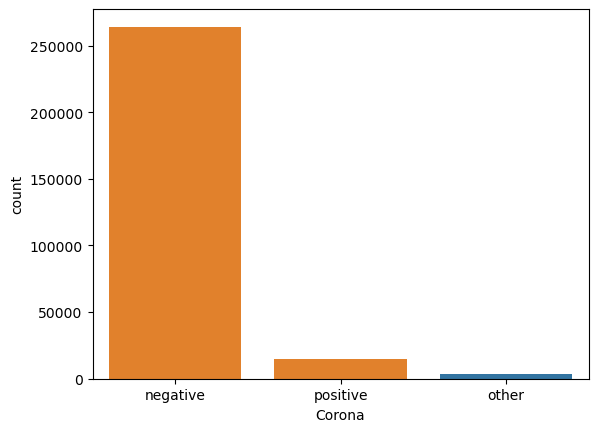

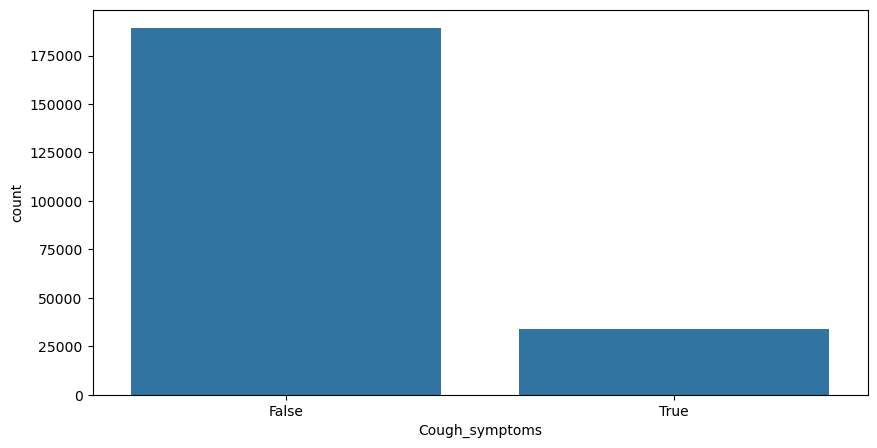

In [32]:
#BARPLOT OF THE 'Cough_symptoms' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Cough_symptoms'].value_counts()).index, y=(X_train[['Cough_symptoms']].value_counts()))
plt.show()

In [33]:
X_train['Fever'].value_counts()

Fever
False    205535
True      17350
Name: count, dtype: int64

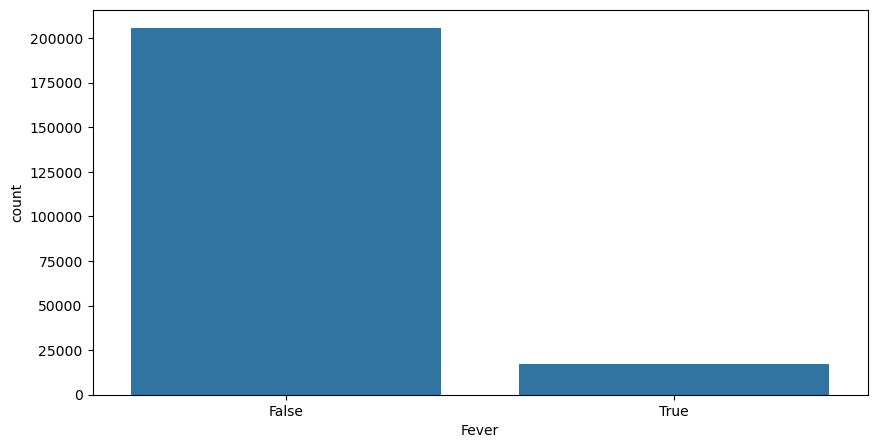

In [34]:
#BARPLOT OF THE 'Fever' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Fever'].value_counts()).index, y=(X_train[['Fever']].value_counts()))
plt.show()

In [35]:
X_train['Sore_throat'].value_counts()

Sore_throat
False    221535
True       1542
Name: count, dtype: int64

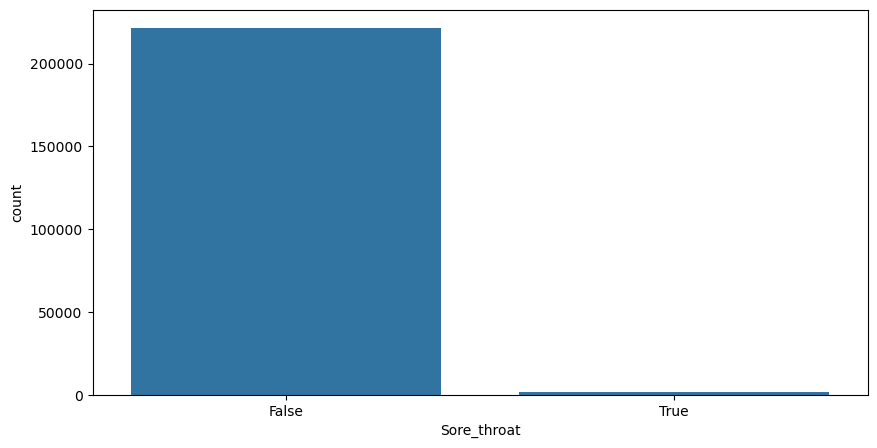

In [36]:
#BARPLOT OF THE 'Sore_throat' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Sore_throat'].value_counts()).index, y=(X_train[['Sore_throat']].value_counts()))
plt.show()

In [37]:
X_train['Shortness_of_breath'].value_counts()

Shortness_of_breath
False    221790
True       1287
Name: count, dtype: int64

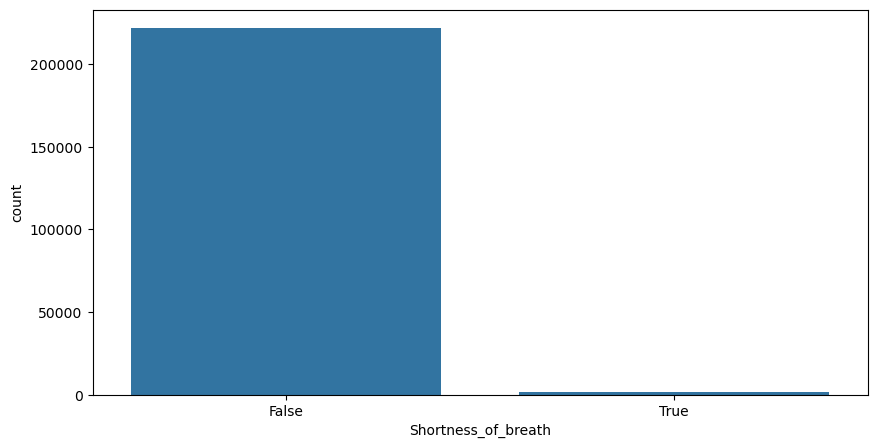

In [38]:
#BARPLOT OF THE 'Shortness_of_breath' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Shortness_of_breath'].value_counts()).index, y=(X_train[['Shortness_of_breath']].value_counts()))
plt.show()

In [39]:
X_train['Headache'].value_counts()

Headache
False    221129
True       1948
Name: count, dtype: int64

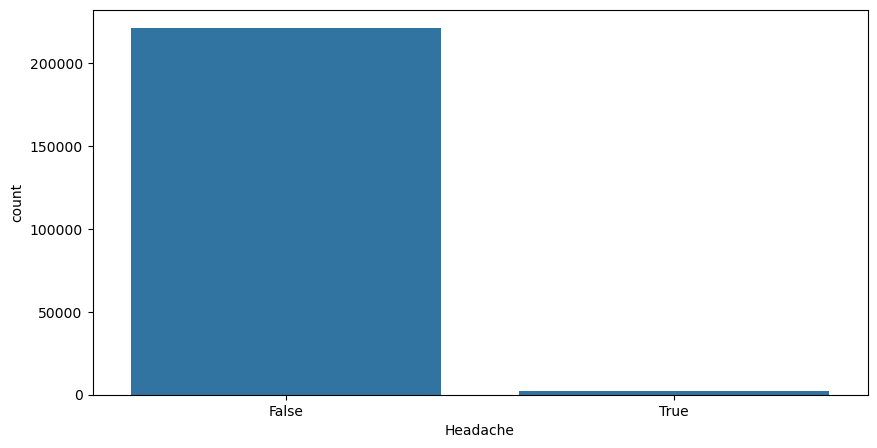

In [40]:
#BARPLOT OF THE 'Headache' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Headache'].value_counts()).index, y=(X_train[['Headache']].value_counts()))
plt.show()

In [41]:
X_train['Age_60_above'].value_counts()

Age_60_above
No     100575
Yes     20664
Name: count, dtype: int64

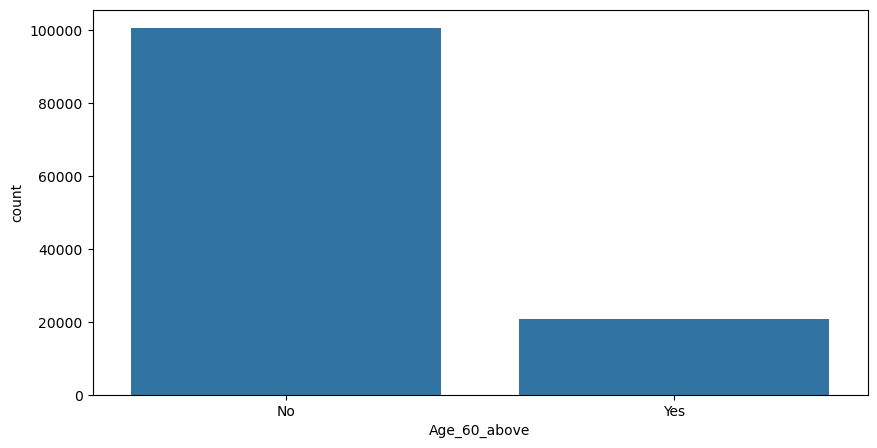

In [42]:
#BARPLOT OF THE 'Age_60_above' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Age_60_above'].value_counts()).index, y=(X_train[['Age_60_above']].value_counts()))
plt.show()

In [43]:
X_train['Sex'].value_counts()

Sex
female    104151
male      103318
Name: count, dtype: int64

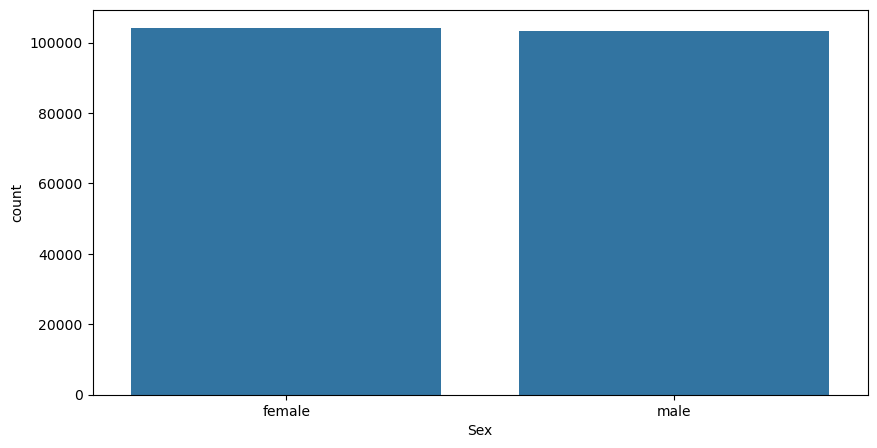

In [44]:
#BARPLOT OF THE 'Sex' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Sex'].value_counts()).index, y=(X_train[['Sex']].value_counts()))
plt.show()

In [45]:
X_train['Known_contact'].value_counts()

Known_contact
Other                     194231
Abroad                     20288
Contact with confirmed      8559
Name: count, dtype: int64

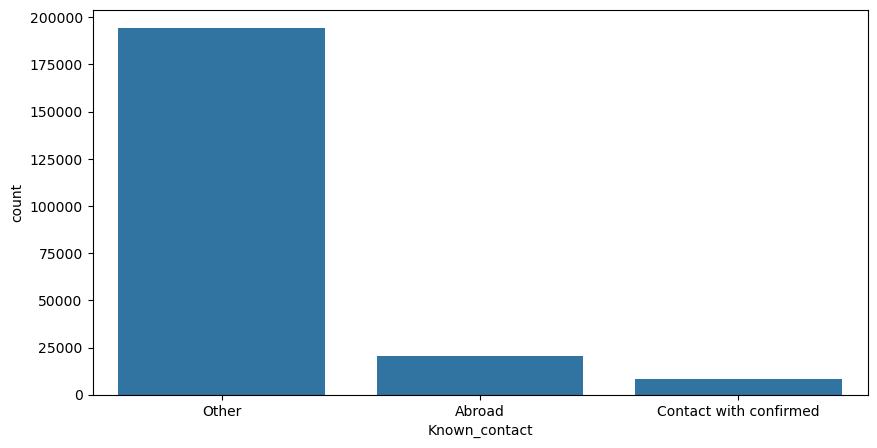

In [46]:
#BARPLOT OF THE 'Known_contact' COLUMN

plt.figure(figsize=(10,5))
sns.barplot(x=(X_train['Known_contact'].value_counts()).index, y=(X_train[['Known_contact']].value_counts()))
plt.show()

# Checking the association of the categorical features with the target variable

In [48]:
#Cramer's V function to find the associations between the categorical features

def cramersv(var1, var2):
    crosstab = np.array(pd.crosstab(var1,var2))   #Making Contingency Table
    stat = chi2_contingency(crosstab)[0]
    N = np.sum(crosstab)
    result = stat/(N*(min(crosstab.shape)-1))  # Cramer's V formula
    return result

In [49]:
X_train.columns

Index(['Ind_ID', 'Test_date', 'Cough_symptoms', 'Fever', 'Sore_throat',
       'Shortness_of_breath', 'Headache', 'Age_60_above', 'Sex',
       'Known_contact'],
      dtype='object')

In [50]:
train = pd.concat((X_train, y_train), axis=1)
train.head()

,Ind_ID,Test_date,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Age_60_above,Sex,Known_contact,Corona
108819,108820,06-04-2020,True,True,False,True,False,No,male,Contact with confirmed,1
274972,274973,30-04-2020,False,False,False,False,False,NaN,female,Other,0
5753,5754,17-03-2020,False,False,False,False,False,No,NaN,Other,0
129524,129525,10-04-2020,False,False,False,False,False,No,male,Other,0
33785,33786,26-03-2020,False,False,False,False,False,No,male,Other,0


In [51]:
columns = ['Cough_symptoms', 'Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache', 'Age_60_above', 'Sex', 'Known_contact', 'Corona']

In [52]:
#Checking the associations between the Independent Categorical Features
rows = []
for col1 in columns:
    col=[]
    for col2 in columns:
        res = cramersv(train[col1], train[col2])
        col.append(round(res,2))
    rows.append(col)
    
cat_corr_matrix = pd.DataFrame(rows, index=columns, columns=columns)
cat_corr_matrix

,Cough_symptoms,Fever,Sore_throat,Shortness_of_breath,Headache,Age_60_above,Sex,Known_contact,Corona
Cough_symptoms,1.00,0.21,0.01,0.01,0.01,0.0,0.0,0.33,0.04
Fever,0.21,1.00,0.02,0.02,0.03,0.0,0.0,0.13,0.07
Sore_throat,0.01,0.02,1.00,0.04,0.10,0.0,0.0,0.03,0.08
Shortness_of_breath,0.01,0.02,0.04,1.00,0.04,0.0,0.0,0.02,0.05
Headache,0.01,0.03,0.10,0.04,1.00,0.0,0.0,0.06,0.13
Age_60_above,0.00,0.00,0.00,0.00,0.00,1.0,0.0,0.00,0.00
Sex,0.00,0.00,0.00,0.00,0.00,0.0,1.0,0.00,0.00
Known_contact,0.33,0.13,0.03,0.02,0.06,0.0,0.0,1.00,0.32
Corona,0.04,0.07,0.08,0.05,0.13,0.0,0.0,0.32,1.00


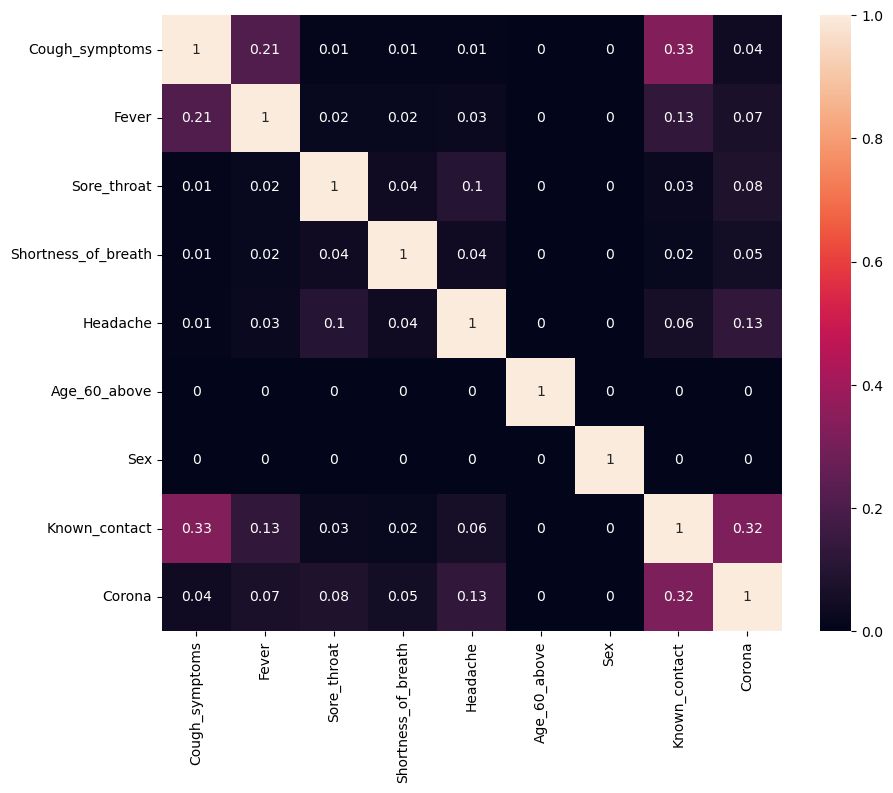

In [53]:
# Heatmap for the correlation measures matrix of the independent categorical features
plt.figure(figsize=(10,8))
sns.heatmap(cat_corr_matrix, annot=True)
plt.show()

In [54]:
X_train = X_train.drop(['Cough_symptoms', 'Age_60_above', 'Sex'], axis=1)
X_train.head(3)

,Ind_ID,Test_date,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
108819,108820,06-04-2020,True,False,True,False,Contact with confirmed
274972,274973,30-04-2020,False,False,False,False,Other
5753,5754,17-03-2020,False,False,False,False,Other


In [55]:
X_test = X_test.drop(['Cough_symptoms', 'Age_60_above', 'Sex'], axis=1)
X_test.head(3)

,Ind_ID,Test_date,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
21877,21878,24-03-2020,False,False,False,False,Other
74261,74262,01-04-2020,False,False,False,False,Other
205400,205401,20-04-2020,False,False,False,False,Other


## Exploring the target feature

In [57]:
y_df = pd.DataFrame(y_train.value_counts())
y_df['percentage'] = round((y_train.value_counts()/y_train.shape[0])*100, 2)
y_df

,count,percentage
Corona,,
0,211295,94.72
1,11783,5.28


In [58]:
test = pd.concat((X_test, y_test), axis=1)
test = test.dropna()

In [59]:
test.isnull().sum()

Ind_ID                 0
Test_date              0
Fever                  0
Sore_throat            0
Shortness_of_breath    0
Headache               0
Known_contact          0
Corona                 0
dtype: int64

In [60]:
X_test = test.drop('Corona', axis=1)
y_test = test['Corona']

# Handling imbalance data

In [62]:
X_train.head(2)

,Ind_ID,Test_date,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
108819,108820,06-04-2020,True,False,True,False,Contact with confirmed
274972,274973,30-04-2020,False,False,False,False,Other


In [63]:
X_train = X_train.drop(['Ind_ID', 'Test_date'],axis=1)

In [64]:
random = RandomUnderSampler(random_state=10)

In [65]:
Xundersampled_data, yundersampled_data = random.fit_resample(X_train, y_train)

In [66]:
Xundersampled_data.shape

(23566, 5)

In [67]:
yundersampled_data.value_counts()

Corona
0    11783
1    11783
Name: count, dtype: int64

# Imputing the null values

In [69]:
Xundersampled_data.head()

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
85060,False,False,False,False,Other
268851,False,False,False,False,Other
78823,False,False,False,False,Other
170950,True,False,False,False,Other
136167,False,False,False,False,Other


In [70]:
#Checking the null values of the training dataset

Xundersampled_data.isnull().sum()

Fever                  39
Sore_throat             1
Shortness_of_breath     1
Headache                1
Known_contact           0
dtype: int64

In [71]:
#CALCULATING THE MISSING PERCENTAGE OF THE TRAINING DATASET(X_train)

missing = pd.DataFrame(Xundersampled_data.isnull().sum(), columns=['missing count'])
missing['missing%'] = round((missing['missing count']/len(Xundersampled_data))*100,2)
missing

,missing count,missing%
Fever,39,0.17
Sore_throat,1,0.00
Shortness_of_breath,1,0.00
Headache,1,0.00
Known_contact,0,0.00


In [72]:
#CONVERTING THE OBJECT DATATYPE OF TRAINING DATASET TO CATEGORY DATATYPE FOR IMPUTING THE MISSING DATA USING MISSINGFOREST
obj_columns = Xundersampled_data.select_dtypes(['object']).columns
Xundersampled_data[obj_columns] = Xundersampled_data[obj_columns].astype('category')

In [73]:
#CONVERTING THE OBJECT DATATYPE OF TESTING DATASET TO CATEGORY DATATYPE FOR IMPUTING THE MISSING DATA USING MISSINGFOREST
obj_columns = X_test.select_dtypes(['object']).columns
X_test[obj_columns] = X_test[obj_columns].astype('category')

In [74]:
Xundersampled_data.head()

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
85060,False,False,False,False,Other
268851,False,False,False,False,Other
78823,False,False,False,False,Other
170950,True,False,False,False,Other
136167,False,False,False,False,Other


In [75]:
X_test = X_test.drop(['Ind_ID', 'Test_date'], axis=1)

In [76]:
Xundersampled_data = Xundersampled_data.reset_index()
yundersampled_data = yundersampled_data.reset_index()

In [77]:
X_test = X_test.reset_index()
y_test = y_test.reset_index()

In [78]:
Xundersampled_data = Xundersampled_data.drop('index', axis=1)
X_test = X_test.drop('index', axis=1)

In [79]:
yundersampled_data = yundersampled_data.drop('index', axis=1)
y_test = y_test.drop('index', axis=1)

In [80]:
#IMPUTING NULL VALUES USING MICEFOREST
imputer = mf.ImputationKernel(Xundersampled_data)
imputer.mice(5)
cleaned_traindataset = imputer.complete_data()

In [81]:
cleaned_traindataset.isnull().sum()

Fever                  0
Sore_throat            0
Shortness_of_breath    0
Headache               0
Known_contact          0
dtype: int64

In [82]:
cleaned_traindataset.shape

(23566, 5)

# Feature Encoding

In [84]:
X_train = cleaned_traindataset.copy()

In [85]:
X_train.head()

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
0,False,False,False,False,Other
1,False,False,False,False,Other
2,False,False,False,False,Other
3,True,False,False,False,Other
4,False,False,False,False,Other


In [86]:
X_train.columns

Index(['Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache',
       'Known_contact'],
      dtype='object')

In [87]:
for column in X_train.columns:
    print(f"{column} :", X_train[column].unique())
    print("\n")

Fever : [False, True]
Categories (2, bool): [False, True]


Sore_throat : [False, True]
Categories (2, bool): [False, True]


Shortness_of_breath : [False, True]
Categories (2, bool): [False, True]


Headache : [False, True]
Categories (2, bool): [False, True]


Known_contact : ['Other', 'Abroad', 'Contact with confirmed']
Categories (3, object): ['Abroad', 'Contact with confirmed', 'Other']




In [88]:
binary_value_features = ['Fever', 'Sore_throat', 'Shortness_of_breath', 'Headache']
for column in binary_value_features:
    X_train[column] = X_train[column].apply(lambda x: 1 if x==True else 0)
    X_test[column] = X_test[column].apply(lambda x: 1 if x==True else 0)

In [89]:
X_train.head()

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact
0,0,0,0,0,Other
1,0,0,0,0,Other
2,0,0,0,0,Other
3,1,0,0,0,Other
4,0,0,0,0,Other


In [90]:
X_train['Known_contact'].value_counts()

Known_contact
Other                     14958
Contact with confirmed     6017
Abroad                     2591
Name: count, dtype: int64

In [91]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [92]:
train_encoded = ohe.fit_transform(X_train[['Known_contact']])
train_encoded

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

In [93]:
kc_train = pd.DataFrame(train_encoded, columns = ohe.get_feature_names_out(['Known_contact']))
kc_train.head(2)

,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other
0,0.0,0.0,1.0
1,0.0,0.0,1.0


In [94]:
transformed_xtrain = pd.concat((X_train, kc_train), axis=1)
transformed_xtrain.head(3)

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other
0,0,0,0,0,Other,0.0,0.0,1.0
1,0,0,0,0,Other,0.0,0.0,1.0
2,0,0,0,0,Other,0.0,0.0,1.0


In [95]:
test_encoded = ohe.transform(X_test[['Known_contact']])
test_encoded

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [96]:
kc_test = pd.DataFrame(test_encoded, columns=ohe.get_feature_names_out(['Known_contact']))
kc_test.head(2)

,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other
0,0.0,0.0,1.0
1,0.0,0.0,1.0


In [97]:
transformed_xtest = pd.concat((X_test, kc_test), axis=1)
transformed_xtest.head(3)

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact,Known_contact_Abroad,Known_contact_Contact with confirmed,Known_contact_Other
0,0,0,0,0,Other,0.0,0.0,1.0
1,0,0,0,0,Other,0.0,0.0,1.0
2,0,0,0,0,Other,0.0,0.0,1.0


In [98]:
transformed_xtrain = transformed_xtrain.drop(['Known_contact', 'Known_contact_Other'], axis=1)
transformed_xtrain.head(2)

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact_Abroad,Known_contact_Contact with confirmed
0,0,0,0,0,0.0,0.0
1,0,0,0,0,0.0,0.0


In [99]:
transformed_xtest = transformed_xtest.drop(['Known_contact', 'Known_contact_Other'], axis=1)
transformed_xtest.head(2)

,Fever,Sore_throat,Shortness_of_breath,Headache,Known_contact_Abroad,Known_contact_Contact with confirmed
0,0,0,0,0,0.0,0.0
1,0,0,0,0,0.0,0.0


In [100]:
transformed_xtrain = transformed_xtrain.astype('float')
transformed_xtest = transformed_xtest.astype('float')

# Training the classification model

In [102]:
# BASE LAYER

class Layer:
    def __init__(self):
        self.input = None
        self.output = None

    #Returns the output of the Activation function
    def forward(self, input):
        raise NotImplementedError

    def back_propagation(self, output_error, learning_rate):
        raise NotImplementedError


# DENSE LAYER
class Dense_layer(Layer):
    def __init__(self, input_size, output_size):
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.random.randn(output_size, 1)
        
    def forward_propagation(self, input):
        self.input = input
        self.output = np.dot(self.weights, self.input) + self.biases
        return self.output

    def backward_propagation(self, output_derivation, learning_rate):
        #Derivations calculation
        weight_derivations = np.dot(output_derivation, self.input.T)
        input_derivations = np.dot(self.weights.T, output_derivation)

        #Parameter updation
        self.weights -= weight_derivations*learning_rate
        self.biases -= output_derivation*learning_rate

        return input_derivations


# ACTIVATION LAYER
class activation_layer(Layer):
    def __init__(self, activation_function, activation_function_prime):
        self.activation_function = activation_function
        self.activation_function_prime = activation_function_prime

    def forward_propagation(self, input):
        self.input = input
        self.output = self.activation_function(self.input)
        return self.output
        
    def backward_propagation(self, output_derivation, learning_rate):
        return np.multiply(output_derivation, self.activation_function_prime(self.input))




In [103]:
# NETWORK

class Network:
    def __init__(self):
        self.layers = []
        self.loss_function = None
        self.loss_function_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def use_loss(self, loss_function, loss_function_prime):
        self.loss_function = loss_function
        self.loss_function_prime = loss_function_prime

    def fit(self, x_train, y_train, epochs, learning_rate):
        prior_output_derivative = 0
        for i in range(epochs):

            #Forward Propagation
            for j in range(len(x_train)):
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

            output_derivative = self.loss_function_prime(y_train[j], output)
            
            current_output_derivative = output_derivative
            
            #Backward Propagation
            for layer in reversed(self.layers):
                output_derivative = layer.backward_propagation(output_derivative, learning_rate)
    
    def predict(self, input):
        result = []
        for i in range(len(input)):
            output = input[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result

In [104]:
# loss function and its derivative
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    # Clip predictions to avoid division by zero
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    return -(y_true*np.log(y_pred) + (1-y_true)*np.log(1-y_pred))

def binary_cross_entropy_prime(y_true, y_pred):
    epsilon = 1e-15
    # Clip predictions to avoid division by zero
    y_pred = np.clip(y_pred, epsilon, 1-epsilon)
    return -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))

In [105]:
# activation function and its derivative
def reLu(x):
    return np.maximum(0, x)

def reLu_prime(x):
    return x>0

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  s = 1 / (1 + np.exp(-x))
  return s * (1 - s)

In [106]:
x_train = transformed_xtrain.values
y_train = yundersampled_data.values
x_test = transformed_xtest.values
y_test = y_test.values

In [107]:
x_train.shape

(23566, 6)

In [241]:
net = Network()

net.add(Dense_layer(6,5))
net.add(activation_layer(reLu, reLu_prime))

net.add(Dense_layer(5,4))
net.add(activation_layer(reLu, reLu_prime))

net.add(Dense_layer(4,1))
net.add(activation_layer(sigmoid, sigmoid_derivative))

net.use_loss(binary_cross_entropy, binary_cross_entropy_prime)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

net.fit(x_train, y_train, epochs=100, learning_rate=0.1)
predicted_values = net.predict(x_test)
predicted_values[:10]


[array([[0.67433145]]),
 array([[0.67433145]]),
 array([[0.67433145]]),
 array([[0.67433145]]),
 array([[0.56167259]]),
 array([[0.56167259]]),
 array([[0.56167259]]),
 array([[0.67433145]]),
 array([[0.67433145]]),
 array([[0.67433145]])]

In [259]:
p = []
for i in range(len(predicted_values)):
    if predicted_values[i][0][0]<0.7:
        p.append(0)
    else:
        p.append(1)

In [261]:
predicted = np.array(p)

In [263]:
confusion_matrix(y_test, predicted)

array([[48973,  3797],
       [  834,  2107]], dtype=int64)

In [265]:
recall_score(y_test, predicted)

0.7164229853791227

In [267]:
precision_score(y_test, predicted)

0.35687669376693765

# ROC CURVE

In [269]:
#Prediction probability

model_proba = []
for i in range(len(predicted_values)):
    model_proba.append(predicted_values[i][0][0])
model_proba[:10]

[0.6743314520463792,
 0.6743314520463792,
 0.6743314520463792,
 0.6743314520463792,
 0.5616725924613122,
 0.5616725924613122,
 0.5616725924613122,
 0.6743314520463792,
 0.6743314520463792,
 0.6743314520463792]

In [271]:
#Getting the values from the roc curve

fpr, tpr, threshold = roc_curve(y_test, model_proba)

In [273]:
#Making a dataframe for the values(fpr, tpr, threshold) of the roc curve

roc_df = pd.DataFrame(zip(fpr, tpr, threshold), columns=['FPR', 'TPR', 'THRES_V'])
roc_df

,FPR,TPR,THRES_V
0,0.000000,0.000000,inf
1,0.000114,0.008501,0.999936
2,0.000133,0.012581,0.999846
3,0.000208,0.019721,0.999543
4,0.000246,0.029922,0.999507
5,0.000303,0.032642,0.999262
6,0.003278,0.143489,0.998873
7,0.003278,0.147229,0.998747
8,0.003278,0.149949,0.998639
9,0.003316,0.150629,0.997803


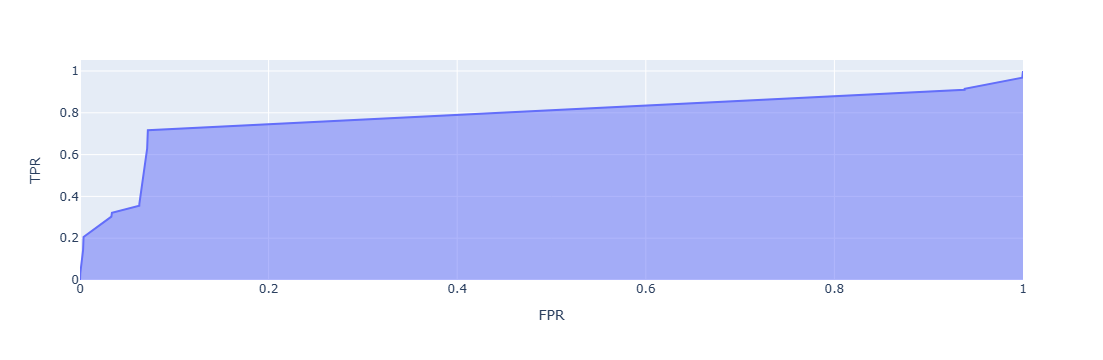

In [275]:
# roc curve for the classifier model

px.area(roc_df,x='FPR', y='TPR', hover_data=['THRES_V'])

In [277]:
#Area under the roc curve
roc_aucArea = roc_auc_score(y_test, model_proba)
roc_aucArea

0.7852393065130242